In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, datasets

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

# Create binary labels for odd/even classification
train_labels_odd_even = train_labels % 2
test_labels_odd_even = test_labels % 2


In [4]:
# CNN Encoder
def create_encoder():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    return models.Model(inputs, x)

encoder = create_encoder()

# Digit classifier model
digit_inputs = layers.Input(shape=(28, 28, 1))
x = encoder(digit_inputs)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
digit_outputs = layers.Dense(10, activation='softmax')(x)
digit_model = models.Model(digit_inputs, digit_outputs)

# Odd/even classifier model
odd_even_inputs = layers.Input(shape=(28, 28, 1))
y = encoder(odd_even_inputs)
y = layers.Flatten()(y)
y = layers.Dense(64, activation='relu')(y)
odd_even_outputs = layers.Dense(2, activation='softmax')(y)
odd_even_model = models.Model(odd_even_inputs, odd_even_outputs)


In [5]:
# Compile models
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
odd_even_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train models
digit_model.fit(train_images, train_labels, epochs=5, validation_split=0.1)
odd_even_model.fit(train_images, train_labels_odd_even, epochs=5, validation_split=0.1)


Epoch 1/5
1688/1688 [==============================] - 60s 35ms/step - loss: 0.1575 - accuracy: 0.9518 - val_loss: 0.0596 - val_accuracy: 0.9832
Epoch 2/5
1688/1688 [==============================] - 56s 33ms/step - loss: 0.0503 - accuracy: 0.9844 - val_loss: 0.0411 - val_accuracy: 0.9885
Epoch 3/5
1688/1688 [==============================] - 56s 33ms/step - loss: 0.0357 - accuracy: 0.9885 - val_loss: 0.0385 - val_accuracy: 0.9895
Epoch 4/5
1688/1688 [==============================] - 54s 32ms/step - loss: 0.0270 - accuracy: 0.9915 - val_loss: 0.0399 - val_accuracy: 0.9898
Epoch 5/5
1688/1688 [==============================] - 53s 32ms/step - loss: 0.0223 - accuracy: 0.9925 - val_loss: 0.0337 - val_accuracy: 0.9907
Epoch 1/5
1688/1688 [==============================] - 56s 32ms/step - loss: 0.0281 - accuracy: 0.9898 - val_loss: 0.0218 - val_accuracy: 0.9940
Epoch 2/5
1688/1688 [==============================] - 54s 32ms/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.0188 - val_ac

In [6]:
# Evaluate models
print("Digit classification performance:")
digit_model.evaluate(test_images, test_labels)

print("Odd/even classification performance:")
odd_even_model.evaluate(test_images, test_labels_odd_even)


Digit classification performance:
313/313 [==============================] - 3s 10ms/step - loss: 0.0470 - accuracy: 0.9848
Odd/even classification performance:
313/313 [==============================] - 3s 10ms/step - loss: 0.0150 - accuracy: 0.9964


[0.01499589066952467, 0.996399998664856]

Feature Maps for Digit Classification Model:
1/1 [==============================] - 0s 66ms/step


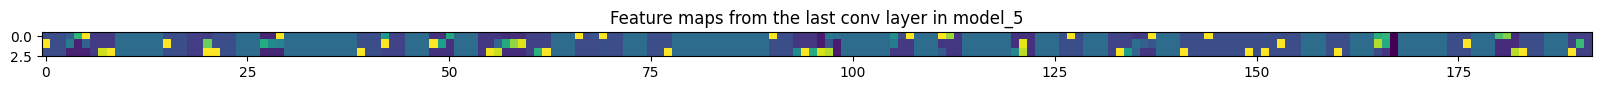

Feature Maps for Odd/Even Classification Model:
1/1 [==============================] - 0s 66ms/step


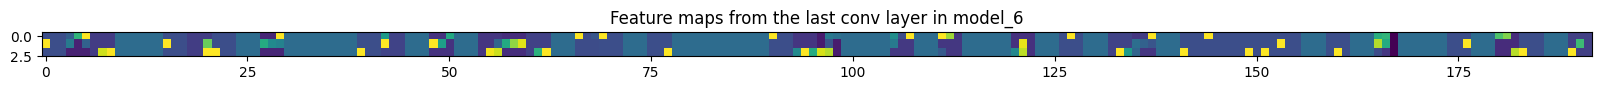

In [12]:
def plot_feature_maps(encoder, model, image_index):
    img = np.expand_dims(test_images[image_index], axis=0)
    # Extract the output of the last convolutional layer in the encoder
    last_conv_output = encoder.get_layer(index=-1).output

    # Creating an intermediate model that will return these outputs, given the encoder input
    intermediate_model = models.Model(inputs=encoder.input, outputs=last_conv_output)
    feature_maps = intermediate_model.predict(img)

    num_maps = feature_maps.shape[-1]
    size = feature_maps.shape[1]
    display_grid = np.zeros((size, size * num_maps))
    for j in range(num_maps):
        x = feature_maps[0, :, :, j]
        x -= x.mean()
        std_dev = x.std()
        if std_dev > 0:
          x /= std_dev
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, j * size : (j + 1) * size] = x
    scale = 20. / num_maps
    plt.figure(figsize=(scale * num_maps, scale))
    plt.title(f'Feature maps from the last conv layer in {model.name}')
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

# Visualize feature maps for the digit classification model
# using the last convolutional layer of the encoder
print("Feature Maps for Digit Classification Model:")
plot_feature_maps(encoder, digit_model, 0)

# Visualize feature maps for the odd/even classification model
# using the last convolutional layer of the encoder
print("Feature Maps for Odd/Even Classification Model:")
plot_feature_maps(encoder, odd_even_model, 0)


In [ ]:
# The feature maps from both the digit classification and odd/even classification models look quite similar, showing that the same underlying features extracted by the encoder are useful for both tasks
# Activation Patterns: Areas highlighted in yellow or green show high activation, indicating important features for making predictions. Darker areas are less important.